## Strategy-3: AI-based generation

In [1]:
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.nn import Parameter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.nn.init import kaiming_normal, calculate_gain
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *
from pggan_networks import Generator,Discriminator

os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    use_gpu = torch.cuda.is_available()
    n_gpu = torch.cuda.device_count()
    print(f"GPU 数量: {n_gpu}")
print(f"运行平台: {device}")

GPU 数量: 1
运行平台: cuda


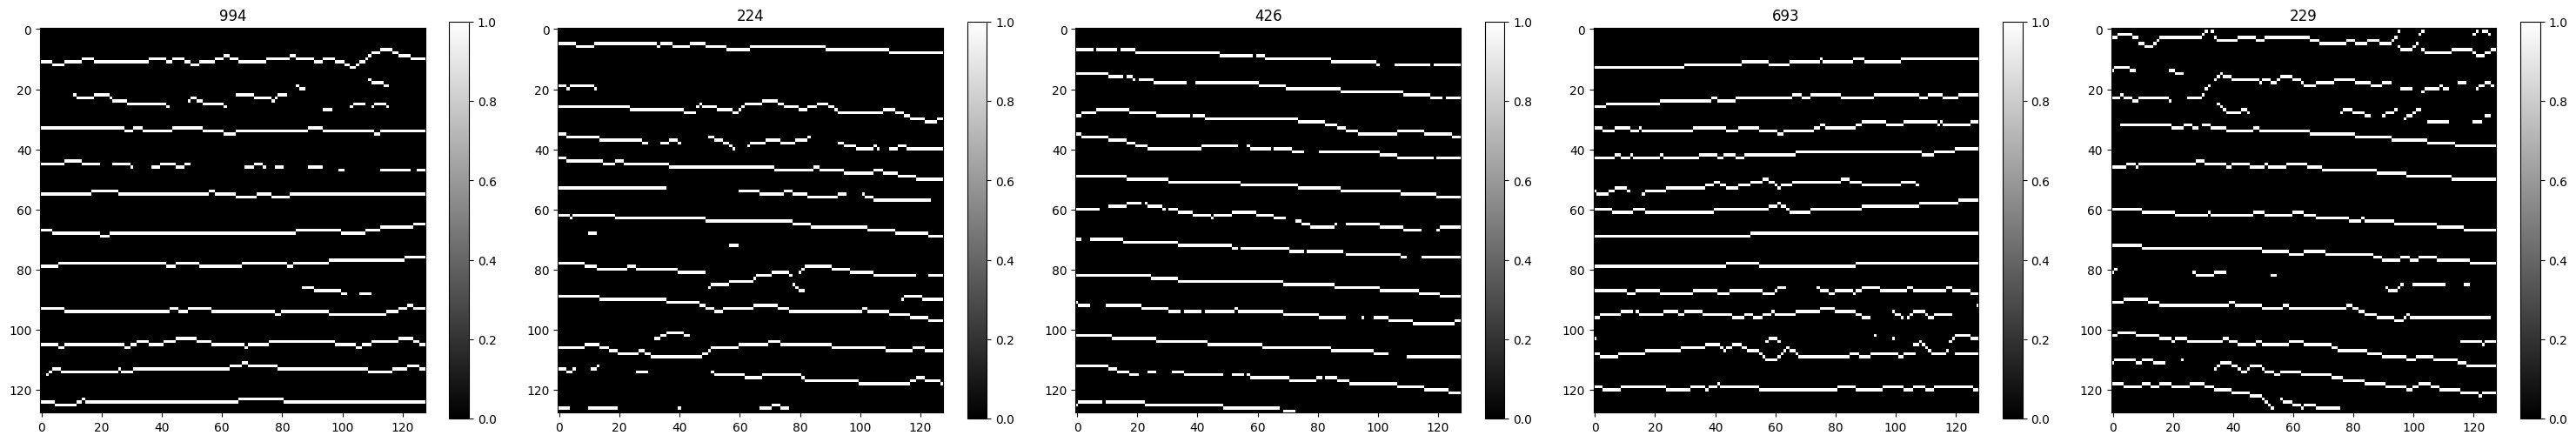

In [3]:
class_name = "parallel"
root_path = os.path.abspath('..')
dataset_name = class_name + "_3"
dataset_path = os.path.join(root_path, "datasets", dataset_name)

# num_sample = 1500
# sample_name_list = []
# for i in range(num_sample):
#     train_sample_file = f'{i}'
#     sample_name_list.append(train_sample_file)
# # 混乱数据集
# random.shuffle(sample_name_list)
# np.save(os.path.join(dataset_path,'samples_' + class_name + '_GAN.npy'), sample_name_list)
# print(f'样本数量：{len(sample_name_list)}')

# visualization
samples_list = np.load(os.path.join(dataset_path,'samples_'+class_name+ '_GAN.npy'), allow_pickle=True)
samples_gt = build_dataset(samples_list,dataset_path)
idxs = np.random.randint(0, len(samples_gt), size=5) 
batch_samples = [samples_gt[i] for i in idxs]
plt.figure(figsize=(30,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch_samples[i].squeeze(),cmap="gray")
    plt.title(str(idxs[i]))
    plt.colorbar()
plt.tight_layout()

In [4]:
# Training parameters setting
image_size = [1, 128, 128]
latent_dim = 128
out_resolusion = 128 # 128*128
total_epochs = 1000
lambd = 10
conv_dim = 128

schedule = [[101, 201, 301, 501, 701], # num of epoches for starting each size
            [16, 16, 16, 16, 16],  # batch size for each size
            [25, 25, 50, 75, 75]]  # num of epoches for alpha transitions 
batch_size = schedule[1][0]
growing = schedule[2][0]

In [5]:
# load networks
generator = Generator(latent_size=latent_dim,out_res=out_resolusion,conv_dim=conv_dim).to(device)
discriminator = Discriminator(latent_size=latent_dim,out_res=out_resolusion,conv_dim=conv_dim).to(device)
g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()),lr=0.0001,betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()),lr=0.0001,betas=(0.5, 0.999))

samples_list = np.load(os.path.join(dataset_path, 'samples_' + class_name + '_GAN.npy'), allow_pickle=True)
samples_gt = build_dataset(samples_list,dataset_path)
# samples_gt = build_dataset(samples_list,dataset_path)
print("Image's value range: [%d ~ %d]"%(samples_gt[0].min(),samples_gt[0].max()) )
dataloader = DataLoader(samples_gt, batch_size=batch_size, shuffle=True, drop_last=True)

c = next(x[0] for x in enumerate(schedule[0]) if x[1]>0)-1
tot_iter_num = (len(samples_gt)/batch_size)
generator.fade_iters = (1-generator.alpha)/(schedule[0][c+1])/(2*tot_iter_num)
discriminator.fade_iters = (1-discriminator.alpha)/(schedule[0][c+1])/(2*tot_iter_num)

size = 2**(generator.depth+1)
print("Output Resolution: %d x %d" % (size, size))

Image's value range: [0 ~ 1]
Output Resolution: 4 x 4


In [6]:
epoch_loss_g = []
epoch_loss_d = []
epoch_loss_real = []
epoch_loss_fake = []
epoch_loss_gp = []
epoch_lr_g,epoch_lr_d = [],[]

checkpoint_path = "./GAN_Network_path/PGGANs_"+class_name+"_"+str(conv_dim)+"_"+str(conv_dim)+"/"
print(checkpoint_path)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

for epoch in range(total_epochs+1):
    generator.train()
    loss_g_per_epoch = 0
    loss_d_per_epoch = 0
    loss_real_per_epoch = 0
    loss_fake_per_epoch = 0
    loss_gp_per_epoch = 0
    
    if epoch in schedule[0]:
        c = schedule[0].index(epoch)
        batch_size = schedule[1][c]
        growing = schedule[2][c]
        dataloader = DataLoader(samples_gt, batch_size=batch_size, shuffle=True, drop_last=True)
        
        tot_iter_num = (len(samples_gt)/batch_size)
        generator.growing_net(growing*tot_iter_num)
        discriminator.growing_net(growing*tot_iter_num)
        size = 2**(generator.depth+1)
        print("Output Resolution: %d x %d" % (size, size))
    
    for i, mini_batch in enumerate(dataloader):
        # load data and resampling dataset
        gt_images = torch.tensor(mini_batch,dtype=torch.float32)
        if size != out_resolusion:
            gt_images = F.interpolate(gt_images, size=size).to(device)
        else:
            gt_images = gt_images.to(device)
            
        # update D    
        d_optimizer.zero_grad()
        z = torch.randn(gt_images.size(0), latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_out = discriminator(fake_images.detach())
        real_out = discriminator(gt_images)
        
        #   # gradient penalty
        eps = torch.rand(gt_images.size(0), 1, 1, 1).to(device)
        eps = eps.expand_as(gt_images)
        x_hat = eps * gt_images + (1 - eps) * fake_images.detach()
        x_hat.requires_grad = True
        px_hat = discriminator(x_hat)
        grad = torch.autograd.grad(outputs = px_hat.sum(),inputs = x_hat,
                                   create_graph=True)[0]
        grad_norm = grad.view(gt_images.size(0), -1).norm(2, dim=1)
        gradient_penalty = lambd * ((grad_norm  - 1)**2).mean()
        ## D LOSS
        d_loss = fake_out.mean() - real_out.mean() + gradient_penalty
        d_loss.backward()
        d_optimizer.step()
        
        # update G
        generator.zero_grad()
        g_fake_out = discriminator(fake_images)
        g_loss = - g_fake_out.mean()
        g_loss.backward()
        g_optimizer.step()
        
        #################################################
        loss_d_per_epoch += d_loss.item()
        loss_g_per_epoch += g_loss.item()
        loss_real_per_epoch += -real_out.mean().item() 
        loss_fake_per_epoch += fake_out.mean().item()
        loss_gp_per_epoch += gradient_penalty.item()
    
    epoch_loss_g.append(loss_g_per_epoch/tot_iter_num)
    epoch_loss_d.append(loss_d_per_epoch/tot_iter_num)
    epoch_loss_real.append(loss_real_per_epoch/tot_iter_num)
    epoch_loss_fake.append(loss_fake_per_epoch/tot_iter_num)
    epoch_loss_gp.append(loss_gp_per_epoch/tot_iter_num)
    epoch_lr_g.append(g_optimizer.param_groups[0]['lr'])
    epoch_lr_d.append(d_optimizer.param_groups[0]['lr'])

    # 保存模型
    if epoch % 50 == 0:
        state = {'epoch': epoch, 'state_dict': generator.state_dict(), 'optimizer': g_optimizer.state_dict()}
        filename = os.path.join(checkpoint_path, 'g-checkpoint-epoch{}.pth'.format(epoch))
        torch.save(state, filename)
        
    if epoch % 1 == 0:
        print("Epoch: %d, G_Loss: %.5f,  D_Loss: %.5f [ %.4f + %.4f + %.4f],  G&D_LR: %.4f + %.4f " %(
            epoch, epoch_loss_g[epoch], epoch_loss_d[epoch],
            epoch_loss_real[epoch], epoch_loss_fake[epoch], epoch_loss_gp[epoch],
            epoch_lr_g[epoch],epoch_lr_d[epoch]))
    
logs = {"epoch_loss_g":epoch_loss_g,
        "epoch_loss_d":epoch_loss_d,
        "epoch_loss_real":epoch_loss_real,
        "epoch_loss_fake":epoch_loss_fake,
        "epoch_loss_gp":epoch_loss_gp,
        "epoch_lr_g":epoch_lr_g,
        "epoch_lr_d":epoch_lr_d,}
np.save(os.path.join(checkpoint_path, 'logs.npy'), logs)

./GAN_Network_path/PGGANs_parallel_128_128/
Epoch: 0, G_Loss: -0.10786,  D_Loss: 0.66879 [ -0.0845 + 0.1097 + 0.6436],  G&D_LR: 0.0001 + 0.0001 
Epoch: 1, G_Loss: 0.04859,  D_Loss: 0.04327 [ -0.0656 + -0.0467 + 0.1556],  G&D_LR: 0.0001 + 0.0001 
Epoch: 2, G_Loss: -0.07988,  D_Loss: 0.17299 [ -0.1005 + 0.0803 + 0.1932],  G&D_LR: 0.0001 + 0.0001 
Epoch: 3, G_Loss: -0.08260,  D_Loss: 0.04467 [ -0.1691 + 0.0832 + 0.1306],  G&D_LR: 0.0001 + 0.0001 
Epoch: 4, G_Loss: -0.11718,  D_Loss: 0.00718 [ -0.2199 + 0.1176 + 0.1095],  G&D_LR: 0.0001 + 0.0001 
Epoch: 5, G_Loss: -0.10348,  D_Loss: -0.03529 [ -0.2438 + 0.1039 + 0.1046],  G&D_LR: 0.0001 + 0.0001 
Epoch: 6, G_Loss: -0.12336,  D_Loss: -0.05662 [ -0.2876 + 0.1235 + 0.1075],  G&D_LR: 0.0001 + 0.0001 
Epoch: 7, G_Loss: -0.14449,  D_Loss: -0.08519 [ -0.3437 + 0.1447 + 0.1138],  G&D_LR: 0.0001 + 0.0001 
Epoch: 8, G_Loss: -0.14632,  D_Loss: -0.12467 [ -0.3900 + 0.1466 + 0.1187],  G&D_LR: 0.0001 + 0.0001 
Epoch: 9, G_Loss: -0.14977,  D_Loss: -0.169

Epoch: 80, G_Loss: 0.12458,  D_Loss: -0.59736 [ -0.5562 + -0.1243 + 0.0831],  G&D_LR: 0.0001 + 0.0001 
Epoch: 81, G_Loss: 0.12989,  D_Loss: -0.59317 [ -0.5526 + -0.1294 + 0.0888],  G&D_LR: 0.0001 + 0.0001 
Epoch: 82, G_Loss: 0.13740,  D_Loss: -0.60265 [ -0.5435 + -0.1372 + 0.0780],  G&D_LR: 0.0001 + 0.0001 
Epoch: 83, G_Loss: 0.14103,  D_Loss: -0.60067 [ -0.5392 + -0.1407 + 0.0792],  G&D_LR: 0.0001 + 0.0001 
Epoch: 84, G_Loss: 0.15204,  D_Loss: -0.59857 [ -0.5287 + -0.1515 + 0.0816],  G&D_LR: 0.0001 + 0.0001 
Epoch: 85, G_Loss: 0.14705,  D_Loss: -0.59761 [ -0.5332 + -0.1468 + 0.0824],  G&D_LR: 0.0001 + 0.0001 
Epoch: 86, G_Loss: 0.14982,  D_Loss: -0.59715 [ -0.5296 + -0.1495 + 0.0820],  G&D_LR: 0.0001 + 0.0001 
Epoch: 87, G_Loss: 0.14594,  D_Loss: -0.59389 [ -0.5302 + -0.1457 + 0.0820],  G&D_LR: 0.0001 + 0.0001 
Epoch: 88, G_Loss: 0.15393,  D_Loss: -0.59427 [ -0.5237 + -0.1535 + 0.0830],  G&D_LR: 0.0001 + 0.0001 
Epoch: 89, G_Loss: 0.16151,  D_Loss: -0.59235 [ -0.5162 + -0.1611 + 0.085

Epoch: 159, G_Loss: 0.98278,  D_Loss: -0.97292 [ -0.0820 + -0.9805 + 0.0895],  G&D_LR: 0.0001 + 0.0001 
Epoch: 160, G_Loss: 0.92005,  D_Loss: -0.91867 [ -0.1143 + -0.9149 + 0.1105],  G&D_LR: 0.0001 + 0.0001 
Epoch: 161, G_Loss: 0.99113,  D_Loss: -0.89087 [ -0.0057 + -0.9858 + 0.1006],  G&D_LR: 0.0001 + 0.0001 
Epoch: 162, G_Loss: 1.04266,  D_Loss: -0.85993 [ 0.0903 + -1.0384 + 0.0881],  G&D_LR: 0.0001 + 0.0001 
Epoch: 163, G_Loss: 1.01935,  D_Loss: -0.80522 [ 0.1353 + -1.0168 + 0.0763],  G&D_LR: 0.0001 + 0.0001 
Epoch: 164, G_Loss: 0.90819,  D_Loss: -0.75188 [ 0.0901 + -0.9077 + 0.0657],  G&D_LR: 0.0001 + 0.0001 
Epoch: 165, G_Loss: 0.76576,  D_Loss: -0.72806 [ -0.0262 + -0.7632 + 0.0613],  G&D_LR: 0.0001 + 0.0001 
Epoch: 166, G_Loss: 0.77722,  D_Loss: -0.71122 [ -0.0008 + -0.7723 + 0.0619],  G&D_LR: 0.0001 + 0.0001 
Epoch: 167, G_Loss: 0.71599,  D_Loss: -0.72442 [ -0.0662 + -0.7154 + 0.0572],  G&D_LR: 0.0001 + 0.0001 
Epoch: 168, G_Loss: 0.82679,  D_Loss: -0.73548 [ 0.0233 + -0.8222 +

Epoch: 238, G_Loss: 0.39543,  D_Loss: -1.55040 [ -1.2646 + -0.3921 + 0.1063],  G&D_LR: 0.0001 + 0.0001 
Epoch: 239, G_Loss: 0.37569,  D_Loss: -1.58644 [ -1.3504 + -0.3566 + 0.1206],  G&D_LR: 0.0001 + 0.0001 
Epoch: 240, G_Loss: 0.16973,  D_Loss: -1.57026 [ -1.5108 + -0.1777 + 0.1183],  G&D_LR: 0.0001 + 0.0001 
Epoch: 241, G_Loss: 0.20243,  D_Loss: -1.54555 [ -1.4815 + -0.1819 + 0.1179],  G&D_LR: 0.0001 + 0.0001 
Epoch: 242, G_Loss: 1.07945,  D_Loss: -1.66833 [ -0.7565 + -1.0469 + 0.1351],  G&D_LR: 0.0001 + 0.0001 
Epoch: 243, G_Loss: 2.26388,  D_Loss: -1.69055 [ 0.4081 + -2.2441 + 0.1454],  G&D_LR: 0.0001 + 0.0001 
Epoch: 244, G_Loss: 2.69906,  D_Loss: -1.59169 [ 0.9654 + -2.6911 + 0.1340],  G&D_LR: 0.0001 + 0.0001 
Epoch: 245, G_Loss: 2.85236,  D_Loss: -1.59337 [ 1.1286 + -2.8402 + 0.1182],  G&D_LR: 0.0001 + 0.0001 
Epoch: 246, G_Loss: 3.43555,  D_Loss: -1.66448 [ 1.6229 + -3.4212 + 0.1339],  G&D_LR: 0.0001 + 0.0001 
Epoch: 247, G_Loss: 2.50496,  D_Loss: -1.67816 [ 0.6820 + -2.5004 + 

Epoch: 318, G_Loss: -0.88261,  D_Loss: -4.68903 [ -6.1054 + 0.8957 + 0.5207],  G&D_LR: 0.0001 + 0.0001 
Epoch: 319, G_Loss: -0.50302,  D_Loss: -4.52955 [ -5.5316 + 0.5147 + 0.4873],  G&D_LR: 0.0001 + 0.0001 
Epoch: 320, G_Loss: -0.99560,  D_Loss: -4.35071 [ -5.7936 + 0.9925 + 0.4504],  G&D_LR: 0.0001 + 0.0001 
Epoch: 321, G_Loss: -1.57914,  D_Loss: -4.23869 [ -6.2410 + 1.5818 + 0.4205],  G&D_LR: 0.0001 + 0.0001 
Epoch: 322, G_Loss: -1.24052,  D_Loss: -4.19584 [ -5.8713 + 1.2746 + 0.4008],  G&D_LR: 0.0001 + 0.0001 
Epoch: 323, G_Loss: -0.17812,  D_Loss: -4.12613 [ -4.7057 + 0.2059 + 0.3737],  G&D_LR: 0.0001 + 0.0001 
Epoch: 324, G_Loss: 1.06250,  D_Loss: -4.17078 [ -3.5242 + -1.0299 + 0.3833],  G&D_LR: 0.0001 + 0.0001 
Epoch: 325, G_Loss: 1.60937,  D_Loss: -3.90237 [ -2.7676 + -1.5337 + 0.3989],  G&D_LR: 0.0001 + 0.0001 
Epoch: 326, G_Loss: 3.03141,  D_Loss: -3.44289 [ -0.7954 + -2.9846 + 0.3371],  G&D_LR: 0.0001 + 0.0001 
Epoch: 327, G_Loss: 3.89586,  D_Loss: -3.57164 [ -0.0111 + -3.85

Epoch: 396, G_Loss: 21.76367,  D_Loss: -3.05459 [ 18.4238 + -21.7376 + 0.2592],  G&D_LR: 0.0001 + 0.0001 
Epoch: 397, G_Loss: 21.56842,  D_Loss: -3.01158 [ 18.2953 + -21.5466 + 0.2397],  G&D_LR: 0.0001 + 0.0001 
Epoch: 398, G_Loss: 21.69027,  D_Loss: -3.04723 [ 18.3663 + -21.6572 + 0.2437],  G&D_LR: 0.0001 + 0.0001 
Epoch: 399, G_Loss: 22.19206,  D_Loss: -3.05573 [ 18.8621 + -22.1638 + 0.2459],  G&D_LR: 0.0001 + 0.0001 
Epoch: 400, G_Loss: 21.52652,  D_Loss: -3.04934 [ 18.1981 + -21.5068 + 0.2594],  G&D_LR: 0.0001 + 0.0001 
Epoch: 401, G_Loss: 21.32763,  D_Loss: -3.00229 [ 18.0494 + -21.2946 + 0.2429],  G&D_LR: 0.0001 + 0.0001 
Epoch: 402, G_Loss: 22.34699,  D_Loss: -3.00043 [ 19.0608 + -22.3056 + 0.2444],  G&D_LR: 0.0001 + 0.0001 
Epoch: 403, G_Loss: 22.77704,  D_Loss: -3.00106 [ 19.5284 + -22.7632 + 0.2337],  G&D_LR: 0.0001 + 0.0001 
Epoch: 404, G_Loss: 22.01054,  D_Loss: -3.01572 [ 18.7161 + -21.9720 + 0.2401],  G&D_LR: 0.0001 + 0.0001 
Epoch: 405, G_Loss: 22.80537,  D_Loss: -3.0125

Epoch: 474, G_Loss: 25.51560,  D_Loss: -2.48900 [ 22.8111 + -25.4965 + 0.1964],  G&D_LR: 0.0001 + 0.0001 
Epoch: 475, G_Loss: 24.60180,  D_Loss: -2.42532 [ 21.9553 + -24.5581 + 0.1775],  G&D_LR: 0.0001 + 0.0001 
Epoch: 476, G_Loss: 25.88106,  D_Loss: -2.45188 [ 23.2142 + -25.8308 + 0.1647],  G&D_LR: 0.0001 + 0.0001 
Epoch: 477, G_Loss: 25.89041,  D_Loss: -2.40749 [ 23.2768 + -25.8721 + 0.1878],  G&D_LR: 0.0001 + 0.0001 
Epoch: 478, G_Loss: 26.43670,  D_Loss: -2.40860 [ 23.8105 + -26.3878 + 0.1687],  G&D_LR: 0.0001 + 0.0001 
Epoch: 479, G_Loss: 24.53365,  D_Loss: -2.39865 [ 21.8950 + -24.4812 + 0.1876],  G&D_LR: 0.0001 + 0.0001 
Epoch: 480, G_Loss: 25.44223,  D_Loss: -2.42327 [ 22.7995 + -25.3968 + 0.1741],  G&D_LR: 0.0001 + 0.0001 
Epoch: 481, G_Loss: 24.81310,  D_Loss: -2.37726 [ 22.2149 + -24.7700 + 0.1779],  G&D_LR: 0.0001 + 0.0001 
Epoch: 482, G_Loss: 25.61482,  D_Loss: -2.38097 [ 23.0483 + -25.6073 + 0.1781],  G&D_LR: 0.0001 + 0.0001 
Epoch: 483, G_Loss: 26.48677,  D_Loss: -2.4286

Epoch: 552, G_Loss: 22.62494,  D_Loss: -5.04308 [ 16.8653 + -22.4662 + 0.5577],  G&D_LR: 0.0001 + 0.0001 
Epoch: 553, G_Loss: 24.91966,  D_Loss: -4.92059 [ 19.3739 + -24.8112 + 0.5168],  G&D_LR: 0.0001 + 0.0001 
Epoch: 554, G_Loss: 26.08288,  D_Loss: -4.83109 [ 20.6101 + -25.9611 + 0.5200],  G&D_LR: 0.0001 + 0.0001 
Epoch: 555, G_Loss: 22.85438,  D_Loss: -4.82401 [ 17.5830 + -22.8879 + 0.4808],  G&D_LR: 0.0001 + 0.0001 
Epoch: 556, G_Loss: 26.81689,  D_Loss: -4.74150 [ 21.4723 + -26.6983 + 0.4844],  G&D_LR: 0.0001 + 0.0001 
Epoch: 557, G_Loss: 26.84404,  D_Loss: -4.71007 [ 21.5657 + -26.7570 + 0.4812],  G&D_LR: 0.0001 + 0.0001 
Epoch: 558, G_Loss: 26.23157,  D_Loss: -4.75903 [ 21.0461 + -26.2802 + 0.4750],  G&D_LR: 0.0001 + 0.0001 
Epoch: 559, G_Loss: 25.01538,  D_Loss: -4.64654 [ 19.8233 + -24.9339 + 0.4640],  G&D_LR: 0.0001 + 0.0001 
Epoch: 560, G_Loss: 23.73215,  D_Loss: -4.73878 [ 18.2846 + -23.5049 + 0.4815],  G&D_LR: 0.0001 + 0.0001 
Epoch: 561, G_Loss: 25.47821,  D_Loss: -4.8033

Epoch: 630, G_Loss: 21.98886,  D_Loss: -4.58421 [ 16.8960 + -21.9715 + 0.4913],  G&D_LR: 0.0001 + 0.0001 
Epoch: 631, G_Loss: 19.30684,  D_Loss: -4.61261 [ 14.1041 + -19.2098 + 0.4930],  G&D_LR: 0.0001 + 0.0001 
Epoch: 632, G_Loss: 21.51404,  D_Loss: -4.61292 [ 16.3039 + -21.4121 + 0.4953],  G&D_LR: 0.0001 + 0.0001 
Epoch: 633, G_Loss: 17.58660,  D_Loss: -4.62859 [ 12.3999 + -17.5257 + 0.4972],  G&D_LR: 0.0001 + 0.0001 
Epoch: 634, G_Loss: 19.07045,  D_Loss: -4.69945 [ 13.8167 + -18.9955 + 0.4794],  G&D_LR: 0.0001 + 0.0001 
Epoch: 635, G_Loss: 21.80680,  D_Loss: -4.67493 [ 16.4949 + -21.6649 + 0.4951],  G&D_LR: 0.0001 + 0.0001 
Epoch: 636, G_Loss: 20.28482,  D_Loss: -4.63645 [ 15.2281 + -20.3590 + 0.4945],  G&D_LR: 0.0001 + 0.0001 
Epoch: 637, G_Loss: 17.34355,  D_Loss: -4.66864 [ 12.0659 + -17.2296 + 0.4951],  G&D_LR: 0.0001 + 0.0001 
Epoch: 638, G_Loss: 15.83403,  D_Loss: -4.52199 [ 10.8568 + -15.8561 + 0.4773],  G&D_LR: 0.0001 + 0.0001 
Epoch: 639, G_Loss: 16.37676,  D_Loss: -4.6075

Epoch: 708, G_Loss: 90.13754,  D_Loss: -44.76397 [ 26.3411 + -90.0814 + 18.9763],  G&D_LR: 0.0001 + 0.0001 
Epoch: 709, G_Loss: 85.35927,  D_Loss: -43.65147 [ 23.6573 + -85.5221 + 18.2133],  G&D_LR: 0.0001 + 0.0001 
Epoch: 710, G_Loss: 80.28670,  D_Loss: -43.81937 [ 18.0448 + -80.0931 + 18.2290],  G&D_LR: 0.0001 + 0.0001 
Epoch: 711, G_Loss: 78.85075,  D_Loss: -42.99915 [ 17.8483 + -78.8826 + 18.0351],  G&D_LR: 0.0001 + 0.0001 
Epoch: 712, G_Loss: 62.37314,  D_Loss: -41.56171 [ 3.8872 + -62.6660 + 17.2171],  G&D_LR: 0.0001 + 0.0001 
Epoch: 713, G_Loss: 49.59759,  D_Loss: -40.37918 [ -7.6258 + -49.4905 + 16.7371],  G&D_LR: 0.0001 + 0.0001 
Epoch: 714, G_Loss: 36.45967,  D_Loss: -36.78321 [ -14.7009 + -36.7419 + 14.6596],  G&D_LR: 0.0001 + 0.0001 
Epoch: 715, G_Loss: 17.94712,  D_Loss: -28.89287 [ -22.1308 + -17.5931 + 10.8310],  G&D_LR: 0.0001 + 0.0001 
Epoch: 716, G_Loss: 31.84048,  D_Loss: -31.36981 [ -9.8525 + -31.4028 + 9.8855],  G&D_LR: 0.0001 + 0.0001 
Epoch: 717, G_Loss: 2.24277,

Epoch: 784, G_Loss: 128.35733,  D_Loss: -10.23488 [ 116.2538 + -128.3729 + 1.8842],  G&D_LR: 0.0001 + 0.0001 
Epoch: 785, G_Loss: 140.63791,  D_Loss: -10.56865 [ 128.0332 + -140.4783 + 1.8764],  G&D_LR: 0.0001 + 0.0001 
Epoch: 786, G_Loss: 131.35389,  D_Loss: -10.43370 [ 118.8278 + -131.1774 + 1.9160],  G&D_LR: 0.0001 + 0.0001 
Epoch: 787, G_Loss: 141.64869,  D_Loss: -10.48413 [ 129.3869 + -141.7326 + 1.8616],  G&D_LR: 0.0001 + 0.0001 
Epoch: 788, G_Loss: 124.62960,  D_Loss: -10.27014 [ 111.9320 + -124.0507 + 1.8486],  G&D_LR: 0.0001 + 0.0001 
Epoch: 789, G_Loss: 129.44096,  D_Loss: -10.36105 [ 117.4156 + -129.6464 + 1.8698],  G&D_LR: 0.0001 + 0.0001 
Epoch: 790, G_Loss: 124.46653,  D_Loss: -10.36543 [ 112.4781 + -124.7318 + 1.8882],  G&D_LR: 0.0001 + 0.0001 
Epoch: 791, G_Loss: 123.88026,  D_Loss: -10.42316 [ 111.2402 + -123.5245 + 1.8612],  G&D_LR: 0.0001 + 0.0001 
Epoch: 792, G_Loss: 125.99597,  D_Loss: -10.45455 [ 113.1853 + -125.6112 + 1.9714],  G&D_LR: 0.0001 + 0.0001 
Epoch: 793

Epoch: 861, G_Loss: 49.97189,  D_Loss: -8.16109 [ 40.2585 + -49.8117 + 1.3921],  G&D_LR: 0.0001 + 0.0001 
Epoch: 862, G_Loss: 77.52075,  D_Loss: -9.12570 [ 66.3996 + -77.0007 + 1.4754],  G&D_LR: 0.0001 + 0.0001 
Epoch: 863, G_Loss: 75.73512,  D_Loss: -8.58029 [ 65.4439 + -75.4502 + 1.4261],  G&D_LR: 0.0001 + 0.0001 
Epoch: 864, G_Loss: 73.11637,  D_Loss: -8.11721 [ 63.5910 + -72.9466 + 1.2383],  G&D_LR: 0.0001 + 0.0001 
Epoch: 865, G_Loss: 67.96398,  D_Loss: -8.64048 [ 58.0727 + -68.0812 + 1.3680],  G&D_LR: 0.0001 + 0.0001 
Epoch: 866, G_Loss: 78.94801,  D_Loss: -8.89683 [ 68.3703 + -78.7533 + 1.4863],  G&D_LR: 0.0001 + 0.0001 
Epoch: 867, G_Loss: 88.43584,  D_Loss: -8.73348 [ 78.0362 + -88.2286 + 1.4589],  G&D_LR: 0.0001 + 0.0001 
Epoch: 868, G_Loss: 96.54331,  D_Loss: -8.95318 [ 85.4926 + -95.9233 + 1.4775],  G&D_LR: 0.0001 + 0.0001 
Epoch: 869, G_Loss: 84.57717,  D_Loss: -8.38500 [ 75.0528 + -84.8424 + 1.4047],  G&D_LR: 0.0001 + 0.0001 
Epoch: 870, G_Loss: 67.89521,  D_Loss: -8.7740

Epoch: 939, G_Loss: 29.37394,  D_Loss: -7.71003 [ 19.8545 + -29.1674 + 1.6029],  G&D_LR: 0.0001 + 0.0001 
Epoch: 940, G_Loss: 69.57752,  D_Loss: -7.38608 [ 60.8308 + -69.3195 + 1.1025],  G&D_LR: 0.0001 + 0.0001 
Epoch: 941, G_Loss: 31.76852,  D_Loss: -7.96639 [ 22.0182 + -31.2943 + 1.3096],  G&D_LR: 0.0001 + 0.0001 
Epoch: 942, G_Loss: 48.06261,  D_Loss: -8.14583 [ 38.5540 + -48.0590 + 1.3592],  G&D_LR: 0.0001 + 0.0001 
Epoch: 943, G_Loss: 64.91222,  D_Loss: -8.17220 [ 55.1765 + -64.6652 + 1.3164],  G&D_LR: 0.0001 + 0.0001 
Epoch: 944, G_Loss: 40.81609,  D_Loss: -8.27720 [ 31.0842 + -40.6351 + 1.2738],  G&D_LR: 0.0001 + 0.0001 
Epoch: 945, G_Loss: 56.86500,  D_Loss: -8.55148 [ 46.4848 + -56.4975 + 1.4612],  G&D_LR: 0.0001 + 0.0001 
Epoch: 946, G_Loss: 46.13318,  D_Loss: -8.46447 [ 36.3392 + -46.1194 + 1.3158],  G&D_LR: 0.0001 + 0.0001 
Epoch: 947, G_Loss: 43.17113,  D_Loss: -8.55736 [ 32.7209 + -42.7721 + 1.4938],  G&D_LR: 0.0001 + 0.0001 
Epoch: 948, G_Loss: 56.34918,  D_Loss: -8.4541

In [7]:
quit()